In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd ./drive/MyDrive/Colab\ Notebooks/
!pwd

[Errno 2] No such file or directory: './drive/MyDrive/Colab Notebooks/'
/content/drive/MyDrive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks


##Learning Deep Representations of Fine-Grained Visual Descriptions

A key challenge in image understanding is to correctly relate natural language concepts to the visual content of images. In other words we aim to learn a text feature representation that captures the most important visual details. 

Based on the method presented by [Scott Reed et al](https://arxiv.org/pdf/1605.05395.pdf) we use the CNN-RNN architecture to build a network that trains on (`image, captions`) combinations and outputs an embedding vector that captures their underlying relationship.

### CNN-RNN

This method stacks a recurrent network (RNN) on top of a mid-level temporal CNN hidden layer.  Intuitively, **the CNN output is split along the time dimension** (in this case the RNN steps are `rnn_steps=8`) and treated as an input sequence of vectors.   



The CNN part of the network takes the text sentence as input and is constructed using the following activation function layers: 

* convolution:  `nn.Conv1d`
* thresholding: `nn.Threshold(1e-6, 0)`
* pooling: `nn.MaxPool1d`    

The RNN part of the network takes the above CNNs output and uses `relu` activation functions without 

The high level model architecture is presented in the following image:

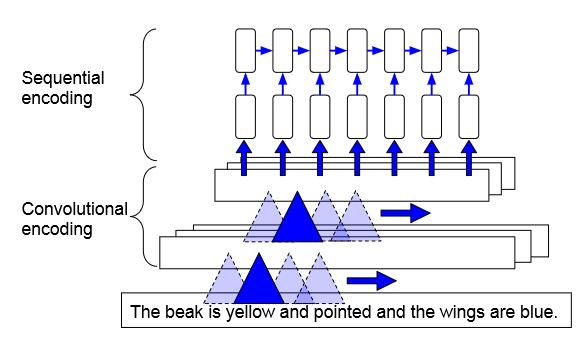

The resulting **scoring function** can be  viewed  as  a  linear  accumulation  of  evidence  for  compatibility with a query image: 

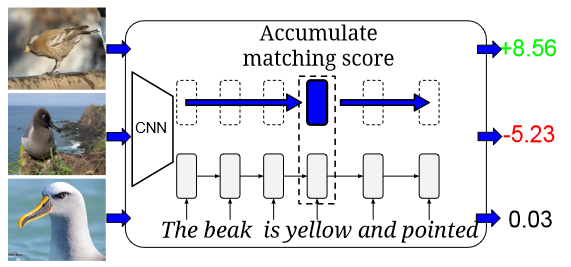

### Text Preprocessing
As described in the original [paper](https://arxiv.org/pdf/1605.05395.pdf), for character-level models (Char-LSTM, Char-CNN, Char-CNN-RNN), the **alphabet** should consist of **all lowercase characters and punctuation**.

The preprocessing steps to transform an english sentence to one-hot tensor are the following:

In [3]:
import torch

In [ ]:
def str_to_labelvec(string, max_str_len):
    string = string.lower()
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "
    alpha_to_num = {k:v+1 for k,v in zip(alphabet, range(len(alphabet)))}
    labels = torch.zeros(max_str_len).long()
    max_i = min(max_str_len, len(string))
    for i in range(max_i):
        labels[i] = alpha_to_num.get(string[i], alpha_to_num[' '])

    return labels

def labelvec_to_onehot(labels):
    labels = torch.LongTensor(labels).unsqueeze(1)

    print(labels)
    
    one_hot = torch.zeros(labels.size(0), 71).scatter_(1, labels, 1.)
    # ignore zeros in one-hot mask (position 0 = empty one-hot)
    one_hot = one_hot[:, 1:]
    one_hot = one_hot.permute(1,0)
    return one_hot

def prepare_text(string, max_str_len=201):
    '''
    Converts a text description from string format to one-hot tensor format.
    '''
    labels = str_to_labelvec(string, max_str_len)

    print(labels)
    one_hot = labelvec_to_onehot(labels)
    return one_hot

In [ ]:
txt = 'A red flower with yellow petals'

txt_one_hot = prepare_text(txt)
input = txt_one_hot.unsqueeze(0)

   
input.size()

In [ ]:
pip install torchfile

In [ ]:
from text_to_image.utils_char_cnn_rnn import extract_char_cnn_rnn_weights

# extract weights from original models
net_state_dict = extract_char_cnn_rnn_weights('./models/lm_sje_cub_c10_hybrid_0.00070_1_10_trainvalids.txt.t7', 'flowers', 'cvpr')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import text_to_image.char_cnn_rnn as ccr

# create Char-CNN-RNN model and load weights
net = ccr('flowers', 'cvpr')
#net.load_state_dict(torch.load(args.weights_out_path))
net.load_state_dict(net_state_dict)
net = net.to(device)
net.eval()
print(net)

In [ ]:
# prepare text and run it through model
# default maximum text length is 201 characters (truncated after that)
txt = 'Text description here'
txt = prepare_text(txt)
txt = txt.unsqueeze(0).to(device)
out = net(txt)
print(out.shape)